# Inteligencia Artificial Aplicada al Análisis de Datos Biológicos


_MeIA_

`2025`

Este conjunto de datos proviene desde el Research Collaboratory for Structure Bioinformatics (RCSB) Protein Data Bank https://www.rcsb.org/docs/programmatic-access/file-download-services

PDB es un repositorio de coordenadas atómicas y otra información que describe proteínas y otras macromoleculas biológicas importantes. 

Los biológos estructurales utilizan mçetodos como la cristalografía de rayos X, la espectroscopia de RMN y la criomicroscopía electrónica para determinar la ubicación de cada átomo en la molécula. Posteriormente, depositan esta información que despues es publicada en PDB.

El dataset contiene dos archivos.
- El primero es un conjunto de metadatos de las biomoleculas, que incluye detalles de su clasificación, métodod de extracción, resolución, etc.

- El segundo contiene 467304 secuencia de las proteínas


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Import Datasets
df_seq = pd.read_csv('./pdb_data_seq.csv')
df_char = pd.read_csv('./pdb_data_no_dups.csv')

In [3]:
df_seq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467304 entries, 0 to 467303
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        467304 non-null  object
 1   chainId            467294 non-null  object
 2   sequence           467276 non-null  object
 3   residueCount       467304 non-null  int64 
 4   macromoleculeType  432487 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.8+ MB


In [4]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141401 entries, 0 to 141400
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               141401 non-null  object 
 1   classification            141399 non-null  object 
 2   experimentalTechnique     141401 non-null  object 
 3   macromoleculeType         137636 non-null  object 
 4   residueCount              141401 non-null  int64  
 5   resolution                128589 non-null  float64
 6   structureMolecularWeight  141401 non-null  float64
 7   crystallizationMethod     96242 non-null   object 
 8   crystallizationTempK      97039 non-null   float64
 9   densityMatthews           124724 non-null  float64
 10  densityPercentSol         124749 non-null  float64
 11  pdbxDetails               118534 non-null  object 
 12  phValue                   105110 non-null  float64
 13  publicationYear           117602 non-null  f

In [5]:
df_char['macromoleculeType'].unique()

array(['DNA/RNA Hybrid', 'DNA', 'Protein', 'Protein#DNA', nan, 'DNA#RNA',
       'RNA', 'DNA#DNA/RNA Hybrid', 'Protein#RNA', 'RNA#DNA/RNA Hybrid',
       'Protein#DNA/RNA Hybrid', 'Protein#DNA#RNA',
       'Protein#DNA#DNA/RNA Hybrid', 'Protein#RNA#DNA/RNA Hybrid'],
      dtype=object)

In [6]:
# Remove null values
df_char = df_char.dropna(subset=['macromoleculeType', 'residueCount'])

# Replace special characters in 'macromoleculeType'
df_char['macromoleculeType'] = df_char['macromoleculeType'].str.replace('#', ' ')
df_char['macromoleculeType'] = df_char['macromoleculeType'].str.replace('/', ' ')

print(df_char['macromoleculeType'].unique())

['DNA RNA Hybrid' 'DNA' 'Protein' 'Protein DNA' 'DNA RNA' 'RNA'
 'DNA DNA RNA Hybrid' 'Protein RNA' 'RNA DNA RNA Hybrid'
 'Protein DNA RNA Hybrid' 'Protein DNA RNA' 'Protein DNA DNA RNA Hybrid'
 'Protein RNA DNA RNA Hybrid']


In [7]:
# Remove null values from the relevant columns in the original dataset
df_char = df_char.dropna(subset=['macromoleculeType', 'residueCount'])

# Recreate 'summary_data' directly by grouping and calculating the mean
summary_data = df_char.groupby('macromoleculeType', as_index=False)['residueCount'].mean()

# Check if 'summary_data' is structured correctly before plotting
summary_data.columns
summary_data.dtypes
summary_data.head(n=20)

,macromoleculeType,residueCount
0,DNA,30.123280
1,DNA DNA RNA Hybrid,18.307692
2,DNA RNA,28.843137
3,DNA RNA Hybrid,26.448276
4,Protein,721.049046
5,Protein DNA,736.706178
6,Protein DNA DNA RNA Hybrid,775.294118
7,Protein DNA RNA,3487.700000
8,Protein DNA RNA Hybrid,521.263158
9,Protein RNA,5583.260407


In [8]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

In [9]:
protein_char.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0
5,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
7,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0
8,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [10]:
protein_char.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127798 entries, 2 to 141400
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               127798 non-null  object 
 1   classification            127797 non-null  object 
 2   experimentalTechnique     127798 non-null  object 
 3   macromoleculeType         127798 non-null  object 
 4   residueCount              127798 non-null  int64  
 5   resolution                117008 non-null  float64
 6   structureMolecularWeight  127798 non-null  float64
 7   crystallizationMethod     87667 non-null   object 
 8   crystallizationTempK      88638 non-null   float64
 9   densityMatthews           114341 non-null  float64
 10  densityPercentSol         114362 non-null  float64
 11  pdbxDetails               108296 non-null  object 
 12  phValue                   95902 non-null   float64
 13  publicationYear           105931 non-null  float6

In [11]:
protein_seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
11,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein
12,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [12]:
protein_seq.describe(include="all")

,structureId,chainId,sequence,residueCount,macromoleculeType
count,345180,345178,345177,345180.000000,345180
unique,127387,2348,89083,NaN,1
top,3J3Q,A,PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...,NaN,Protein
freq,1356,123105,2580,NaN,345180
mean,NaN,NaN,NaN,4717.870508,NaN
std,NaN,NaN,NaN,26527.126728,NaN
min,NaN,NaN,NaN,3.000000,NaN
25%,NaN,NaN,NaN,398.000000,NaN
50%,NaN,NaN,NaN,856.000000,NaN
75%,NaN,NaN,NaN,1976.000000,NaN


In [13]:
protein_char.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

In [14]:
# Select  some variables to join
protein_char = protein_char[['structureId','classification','residueCount', 'resolution',
       'structureMolecularWeight','crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'phValue']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [15]:
protein_char.head()

,structureId,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue
2,101M,OXYGEN TRANSPORT,154,2.07,18112.80,NaN,3.09,60.20,9.0
4,102L,HYDROLASE(O-GLYCOSYL),165,1.74,18926.61,NaN,2.75,55.28,NaN
5,102M,OXYGEN TRANSPORT,154,1.84,18010.64,NaN,3.09,60.20,9.0
7,103L,HYDROLASE(O-GLYCOSYL),167,1.90,19092.72,NaN,2.70,54.46,NaN
8,103M,OXYGEN TRANSPORT,154,2.07,18093.78,NaN,3.09,60.30,9.0


In [16]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence
structureId,,,,,,,,,
101M,OXYGEN TRANSPORT,154,2.07,18112.80,NaN,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),165,1.74,18926.61,NaN,2.75,55.28,NaN,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,154,1.84,18010.64,NaN,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),167,1.90,19092.72,NaN,2.70,54.46,NaN,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,154,2.07,18093.78,NaN,3.09,60.30,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [17]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

346325 is the number of rows in the joined dataset


In [18]:
# Check NA counts
model_f.isnull().sum()

classification                   1
residueCount                     0
resolution                   16093
structureMolecularWeight         0
crystallizationTempK        102391
densityMatthews              38844
densityPercentSol            38710
phValue                      87195
sequence                         3
dtype: int64

In [19]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

214106 is the number of proteins that have a classification and sequence


classification
HYDROLASE                               29726
TRANSFERASE                             24338
OXIDOREDUCTASE                          22578
IMMUNE SYSTEM                           11087
HYDROLASE/HYDROLASE INHIBITOR            9569
                                        ...  
DYE-BINDING PROTEIN                         1
CHAPERONE REGULATOR                         1
pyridoxal phosphate binding                 1
IMMUNE SYSTEM, LIPID BINDING PROTEIN        1
lipid transport/activator                   1
Name: count, Length: 2458, dtype: int64


/var/folders/0j/lsgw_9pn4jb8tydzmww2k9c40000gn/T/ipykernel_11255/467189256.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(counts, hist = False, color = 'purple')
/Users/galanve/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


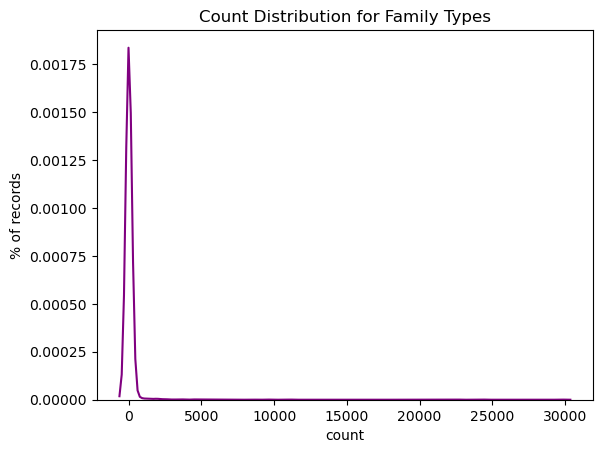

In [20]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [21]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)
print(len(types))
# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]
data = data.drop_duplicates(subset=["classification","sequence"])  # leaving more rows results in duplciates / index related?

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

32
['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM'
 'HYDROLASE/HYDROLASE INHIBITOR' 'LYASE' 'TRANSCRIPTION'
 'TRANSPORT PROTEIN' 'ISOMERASE' 'VIRAL PROTEIN' 'SIGNALING PROTEIN'
 'LIGASE' 'PROTEIN BINDING' 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'
 'TRANSFERASE/TRANSFERASE INHIBITOR' 'MEMBRANE PROTEIN'
 'SUGAR BINDING PROTEIN' 'UNKNOWN FUNCTION' 'DNA BINDING PROTEIN'
 'CHAPERONE' 'STRUCTURAL PROTEIN' 'METAL BINDING PROTEIN' 'CELL ADHESION'
 'ELECTRON TRANSPORT' 'PROTEIN TRANSPORT'
 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR' 'TOXIN' 'RNA BINDING PROTEIN'
 'CELL CYCLE' 'PHOTOSYNTHESIS' 'GENE REGULATION' 'DE NOVO PROTEIN']
46422 is the number of records in the final filtered dataset


In [22]:
data = data.drop_duplicates(subset=["classification","sequence"])
data.shape

(46422, 9)

In [23]:
## Could add n-grams
## https://stackoverflow.com/questions/18658106/quick-implementation-of-character-n-grams-using-python
# jump_size !=1 -> less overlap in n-grams.
def char_grams(text,n=3,jump_size=2):
    return [text[i:i+n] for i in range(0,len(text)-n+1,jump_size)]

In [24]:
data.head(3).sequence.apply(char_grams)

structureId
1A4S    [AQL, LVD, DSM, MPS, SAS, STG, GSV, VVV, VTD, ...
1A6Q    [MGA, AFL, LDK, KPK, KME, EKH, HNA, AQG, GQG, ...
1A72    [STA, AGK, KVI, IKC, CKA, AAV, VLW, WEE, EKK, ...
Name: sequence, dtype: object

In [25]:
data["3mers"] = data.sequence.apply(char_grams)

In [26]:
data.tail()

,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence,3mers
structureId,,,,,,,,,,
6FFL,SUGAR BINDING PROTEIN,388,1.71,44992.17,291.0,2.59,53.00,5.5,EDVRIQIWHQMIYGHRQVLAEALEKFEKENPGITVQATYRETEELR...,"[EDV, VRI, IQI, IWH, HQM, MIY, YGH, HRQ, QVL, ..."
6FG7,PROTEIN BINDING,500,1.90,56392.64,298.0,3.39,63.68,4.0,MKEIGSKPRKLLPLCFIIFLCFCSSVMAADEDDIRCLRGLKASLTD...,"[MKE, EIG, GSK, KPR, RKL, LLP, PLC, CFI, IIF, ..."
6FG8,PROTEIN BINDING,506,1.25,58478.36,298.0,1.86,33.78,5.5,MTRLTVLALLAGLLASSRAGSSMASANLEGDALHTLRVTLVDPNNV...,"[MTR, RLT, TVL, LAL, LLA, AGL, LLA, ASS, SRA, ..."
6FG8,PROTEIN BINDING,506,1.25,58478.36,298.0,1.86,33.78,5.5,MKKIFITLLWLLFISSFLCSSSSAEDDVLCLQGLKNSLIDPSSRLS...,"[MKK, KIF, FIT, TLL, LWL, LLF, FIS, SSF, FLC, ..."
6FIF,PROTEIN BINDING,837,2.54,93918.31,298.0,3.32,62.96,4.0,MKTFSSFFLSVTTLFFFSFFSLSFQASPSQSLYREIHQLISFKDVL...,"[MKT, TFS, SSF, FFL, LSV, VTT, TLF, FFF, FSF, ..."


In [27]:
data.to_csv("protein_classification_46k_ngrams.csv.gz",compression="gzip")

In [28]:
# 3). ----- Train Test Split -----

# Split Data
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names_out()[-20:])

['zhhh' 'ziar' 'zigi' 'ziwz' 'zkal' 'zkky' 'zknt' 'zkyh' 'zlik' 'zlzk'
 'zpvm' 'zrgd' 'zrvi' 'ztvl' 'ztzk' 'zvbd' 'zvib' 'zvka' 'zwdl' 'zzvb']


In [ ]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train_df,y_train)

In [ ]:
preds = model.predict(X_test_df)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,preds))
print('\n')
print(classification_report(y_test,preds))

In [ ]:
# 4). ------ Machine Learning Models ------

# Make a prediction dictionary to store accuracys
prediction = dict()

# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])